In [3]:
# This file takes code from Outsourcers and LS and compares what happens under
# similar parameters. Particularly interested in average wages, worker and total welfare,
# and percent of efficiency achieved.

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, jitclass, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize
import os

# This class works for all models
class OutsourcingBaseline:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    c_o is level of cost
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, gamma, c_grid, c_o
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.delta_hat, self.eta_o, self.c_o = delta_hat, eta_o, c_o 
        self.delta_o = delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.phi, self.alpha = phi, alpha
        
# Set up neccesary functions for Outsourcing
def operator_factory(ob):
    
    r, b, delta, eta, gamma, c_grid = ob.r, ob.b, ob.delta, ob.eta, ob.gamma, ob.c_grid
    delta_hat, eta_o, c_o = ob.delta_hat, ob.eta_o, ob.c_o
    delta_o = ob.delta_o
    phi, alpha = ob.phi, ob.alpha
    
    y_grid, y_grid_size, rm, y_max = ob.y_grid, ob.y_grid_size, ob.rm, ob.y_max    
    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    
    # Given n_hat_grid, y_hat, and theta, find n_o (and v_o) that clears market
    @njit()
    def clear_market(n_hat_grid, y_hat, theta):
        y_i = find_y_i(y_hat)
        n_o = np.sum(n_hat_grid[y_i:] * rm) 
        v_o = delta_o * n_o / q(theta)
        return v_o, n_o
    
    # Given v_grid, v_o, n_grid, n_o, and y_hat find the distribution of workers
    # Including index y_i, market tightness theta, 
    # fraction of outsourcing vacancies pi, and distribution of vacancies f_grid
    @njit()
    def worker_dist(v_grid, v_o, n_grid, n_o, y_hat):
    
        y_i = find_y_i(y_hat)
        
        # These are useful
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_temp * rm), 1e-9)
        u = max(1 - n - n_o, 1e-9)
        v = max(np.sum(v_temp * rm), 1e-9)
        
        # Calculate theta and pi 
        v_sum = v + v_o
        theta = v_sum / u
        pi = v_o / v_sum
        
        # f is pdf of vacancies 
        f_grid = v_temp / v
        
        return y_i, theta, pi, f_grid
    
    # Solve decentralized problem
    # Given v_grid, v_o, n_grid, n_o, and y_hat, find
    # Market tightness theta
    # Wages w and w_o and price p
    @njit()
    def make_grids(v_grid, v_o, n_grid, n_o, y_hat):    
        
        # Get distribution of workers
        y_i, theta, pi, f_grid = worker_dist(v_grid, v_o, n_grid, n_o, y_hat)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        firm = eta / (1 - eta) * (1 - pi) * f_tot
        out = eta_o / (1 - eta_o) * pi * c_o
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # Find price
        p = b + Gamma_U + (r + delta_o) / ((1 - eta_o) * q(theta)) * c_o
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U) 
        w_o = eta_o * p + (1 - eta_o) * (b + Gamma_U) 
        
        return y_i, theta, pi, f_grid, Gamma_U, p, w_grid, w_o
    
    # Given v_grid, v_hat_grid, v_o, n_grid, n_hat_grid,
    # n_o, y_hat, and p, find new values
    @njit()
    def iterate(v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat):
        
        y_i, theta, pi, f_grid, Gamma_U, p, w_grid, w_o = make_grids(v_grid, v_o, n_grid, n_o, y_hat)
        
        # Value of firms
        J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
        J_out = (y_grid - p) / (r + delta_hat)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Chose these values for outsourcers st the outsourcing market clears
        v_o_new, n_o_new = clear_market(n_hat_grid_new, y_hat_new, theta)
                       
        return v_grid_new, v_hat_grid_new, v_o_new, n_grid_new, n_hat_grid_new, n_o_new, y_hat_new  
    
    # Solve Planner's problem
    # Given v_grid, v_o, n_grid, n_o, and y_hat find
    # Market tightness theta
    # Planner's value of worker search Gamma_P
    # The lagrange multipliers rho (price), lamda_grid, mu_grid, iota
    @njit()
    def p_make_grids(v_grid, v_o, n_grid, n_o, y_hat):    
        
        # Get distribution of workers
        y_i, theta, pi, f_grid = worker_dist(v_grid, v_o, n_grid, n_o, y_hat)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_P = ell(theta) / q(theta) * alpha / (1 - alpha) * ((1 - pi) * f_tot + pi * c_o)
        
        # Find price rho
        rho = b + Gamma_P + (r + delta_o) / q(theta) * (c_o + Gamma_P / theta)
        
        # Find lagrange multipliers lamda_grid, mu_grid, and iota
        lambda_grid = (y_grid - b - Gamma_P) / (r + delta)
        mu_grid = (y_grid - rho) / (r + delta_hat)
        
        return y_i, theta, pi, f_grid, Gamma_P, rho, lambda_grid, mu_grid
    
    # Given v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat find new values
    @njit()
    def p_iterate(v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat):
        
        # Get theta, Gamma_P, rho, lambda_grid, and mu_grid
        y_i, theta, pi, f_grid, Gamma_P, rho, lambda_grid, mu_grid = p_make_grids(v_grid, v_o, n_grid, n_o, y_hat)
        
        # Value of firms
        J_hire = lambda_grid * q(theta) - Gamma_P / theta
        J_out = mu_grid
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        # Make sure J_out is non_negative at y_hat
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_zero = np.argmin(np.abs(J_out))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcing firms (above y_hat)
        v_hat_grid_new = c_inv(J_out)
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
        
        # Outsourcing firms
        n_hat_grid_new = (1 - delta_hat) * n_hat_grid + v_hat_grid_new
        
        # Chose these values for outsourcers st the outsourcing market clears
        v_o_new, n_o_new = clear_market(n_hat_grid_new, y_hat_new, theta)
                       
        return v_grid_new, v_hat_grid_new, v_o_new, n_grid_new, n_hat_grid_new, n_o_new, y_hat_new
    
    return iterate, make_grids, p_iterate, p_make_grids, find_y_i, clear_market, C, c, c_inv, q, ell 

# Solve model, both decentralized and Planner 
def solve_model(ob, guess, tol, max_iter, slow, planner=False, verbose=False, print_skip=1e4):
    
    if planner == False:
        iterate, _, _, _, _, _, _, _, _, _, _ = operator_factory(ob)
    else:
        _, _, iterate, _, _, _, _, _, _, _, _ = operator_factory(ob)
    
    v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        (v_grid_new, v_hat_grid_new, v_o_new, n_grid_new,
                n_hat_grid_new, n_o_new, y_hat_new) = iterate(
            v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat
        )
        err_v_t = np.max(np.abs(v_grid_new - v_grid))
        err_v_h = np.max(np.abs(v_hat_grid_new - v_hat_grid))
        err_v_o = np.abs(v_o_new - v_o)
        err_n_t = np.max(np.abs(n_grid_new - n_grid))
        err_n_h = np.max(np.abs(n_hat_grid_new - n_hat_grid))
        err_n_o = np.abs(n_o_new - n_o)
        err = max(err_v_t, err_v_h, err_v_o, err_n_t, err_n_h, err_n_o)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        v_hat_grid = slow * v_hat_grid_new + (1 - slow) * v_hat_grid
        v_o = slow * v_o_new + (1 - slow) * v_o
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        n_hat_grid = slow * n_hat_grid_new + (1 - slow) * n_hat_grid
        n_o = slow * n_o_new + (1 - slow) * n_o
        y_hat = slow * y_hat_new + (1 - slow) * y_hat 
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter and verbose:
        print(f'Converged in {i} iterations')
    if i == max_iter and verbose:
        print(f'Failed to Converge.')

    return v_grid_new, v_hat_grid_new, v_o_new, n_grid_new, n_hat_grid_new, n_o_new, y_hat_new

# This is from LS, but will also take ob and work
def ls_operator_factory(ls):
    
    r, b, delta, eta, gamma, c_grid = ls.r, ls.b, ls.delta, ls.eta, ls.gamma, ls.c_grid
    phi, alpha = ls.phi, ls.alpha
    
    y_grid, y_grid_size, rm, y_max = ls.y_grid, ls.y_grid_size, ls.rm, ls.y_max    
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        
        # Calculate theta 
        theta = v / u
        
        # f is pdf of vacancies 
        f_grid = v_grid / v
        
        return theta, f_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_U = ell(theta) / q(theta) * eta / (1 - eta) * f_tot
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U)
        
        return theta, f_grid, Gamma_U, w_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def iterate(v_grid, n_grid):
        
        theta, f_grid, Gamma_U, w_grid = make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * (y_grid - w_grid) / (r + delta)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    # Solve Planner's problem
    # Given v_grid and n_grid find
    # Market tightness theta
    # Planner's value of worker search Gamma_P
    # The lagrange multiplier lamda_grid
    @njit()
    def p_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid = worker_dist(v_grid, n_grid)
        
        # What is the value of search for unemployed?
        f_tot = np.sum(c(v_grid) * f_grid * rm)
        Gamma_P = ell(theta) / q(theta) * alpha / (1 - alpha) * f_tot
        
        # Find lagrange multiplier lamda_grid
        lambda_grid = (y_grid - b - Gamma_P) / (r + delta)
        
        return theta, f_grid, Gamma_P, lambda_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def p_iterate(v_grid, n_grid):
        
        # Get theta, Gamma_P, and lambda_grid
        theta, f_grid, Gamma_P, lambda_grid = p_make_grids(v_grid, n_grid)
        
        # Value of firms
        J_hire = lambda_grid * q(theta) - Gamma_P / theta
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * n_grid + q(theta) * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return iterate, make_grids, p_iterate, p_make_grids, C, c, c_inv, q, ell 

# Solve model, both decentralized and Planner 
def ls_solve_model(ls, guess, tol, max_iter, slow, planner=False, verbose=False, print_skip=1e4):
    
    if planner == False:
        iterate, _, _, _, _, _, _, _, _ = ls_operator_factory(ls)
    else:
        _, _, iterate, _, _, _, _, _, _ = ls_operator_factory(ls)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter and verbose:
        print(f'Converged in {i} iterations')
    if i == max_iter and verbose:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

# Create a function that creates a new folder and saves the parameters to that folder
def save_parameters(params, f):
    
    # Retrieve parameters
    (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, gamma, c_0, c_1, c_o) = params
    
    f.write(f"""
    These are the parameters used for this simulation:
    B = {B} 
    r = {r} 
    delta = {delta} 
    delta_o = {delta_o} 
    delta_hat = {delta_hat}  
    eta = {eta} 
    eta_o = {eta_o} 
    phi = {phi} 
    alpha = {alpha} 
    y_min = {y_min}
    y_max = {y_max}
    y_grid_size = {y_grid_size}
    b = {b}
    gamma = {gamma}
    c_0 = {c_0}
    c_1 = {c_1}
    c_o = {c_o}
    """)

# New to this file, given set of parmeter values, create an instance of OutsourcersBasic
# and find the decentralized and Planner's solution with and without outsourcing.
# Then compare
def compare_eqba(params, tol=1e-8, max_iter=1e5, slow=1e-1, verbose=True, out=False):
    
    # Retrieve parameters
    (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, gamma, c_0, c_1, c_o) = params
    
    y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
    c_grid = np.exp(c_0 + c_1 * y_grid)
    
    # Set up class
    ob = OutsourcingBaseline(B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, gamma, c_grid, c_o)
    
    rm = ob.rm
    
    # Functions I will later need
    _, make_grids, _, p_make_grids, find_y_i, _, C, c, c_inv, q, ell = operator_factory(ob)
    _, ls_make_grids, _, ls_p_make_grids, _, _, _, _, _ = ls_operator_factory(ob)
    
    # LS decentralized
    v_grid_ls = np.ones(y_grid_size) / y_grid_size**2
    n_grid_ls = np.ones(y_grid_size) / y_grid_size**2
    
    guess = v_grid_ls, n_grid_ls
    
    v_grid_ls, n_grid_ls = ls_solve_model(ob, guess, tol, max_iter, slow, planner=False, verbose=False)
    
    theta_ls, f_grid_ls, Gamma_U_ls, w_grid_ls = ls_make_grids(v_grid_ls, n_grid_ls)
    
    u_ls = 1 - np.sum(n_grid_ls * rm)
    
    U_ls = (1 + r) * (b + Gamma_U_ls) / r
    W_ls = ((1 + r) * w_grid_ls + delta * U_ls) / (r + delta)
    J_ls = (1 + r) * (y_grid - w_grid_ls) / (r + delta)
    
    w_welfare_ls = np.sum(n_grid_ls * W_ls * rm) + u_ls * U_ls
    f_welfare_ls = np.sum(n_grid_ls * J_ls * rm) - np.sum(C(v_grid_ls) * rm) 
    tot_welfare_ls = w_welfare_ls + f_welfare_ls
    
    w_mean_ls = np.sum(n_grid_ls * w_grid_ls * rm) / np.sum(n_grid_ls * rm)
    
    # LS Planner (decentralized as guess)
    guess = v_grid_ls, n_grid_ls
    
    v_grid_ls_p, n_grid_ls_p = ls_solve_model(ob, guess, tol, max_iter, slow, planner=True, verbose=False)
    
    theta_ls_p, f_grid_ls_p, Gamma_P_ls, lambda_grid_ls = ls_p_make_grids(v_grid_ls_p, n_grid_ls_p)
    
    u_ls_p = 1 - np.sum(n_grid_ls_p * rm)
    
    tot_welfare_ls_p = (
        (np.sum(n_grid_ls_p * y_grid * rm) + u_ls_p * b - np.sum(C(v_grid_ls_p) * rm))
        * (1 + r) / r
    )
    
    # Outsourcer decentralized
    v_grid = np.ones(y_grid_size) / y_grid_size**2
    n_grid = np.ones(y_grid_size) / y_grid_size**2
    v_hat_grid = np.ones(y_grid_size) / y_grid_size**2
    n_hat_grid = np.ones(y_grid_size) / y_grid_size**2
    v_o = 1 / y_grid_size**2
    n_o = 1 / y_grid_size**2
    y_hat = (y_max + y_min) / 2
    
    guess = v_grid_ls, v_grid_ls, v_o, n_grid_ls, n_grid_ls, n_o, y_hat

    v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat = solve_model(
        ob, guess, tol, max_iter, slow, planner=False, verbose=False)
    
    y_i, theta, pi, f_grid, Gamma_U, p, w_grid, w_o = make_grids(v_grid, v_o, n_grid, n_o, y_hat)
    
    u = 1 - np.sum(n_grid[:y_i] * rm) - n_o
    zeta = n_o / (n_o + np.sum(n_grid[:y_i] * rm))
    
    U = (1 + r) * (b + Gamma_U) / r
    W = ((1 + r) * w_grid + delta * U) / (r + delta)
    W_o = ((1 + r) * w_o + delta_o * U) / (r + delta_o)
    J = (1 + r) * (y_grid - w_grid) / (r + delta)
    J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
    O = (1 + r) * (p - w_o) / (r + delta_o)
    
    w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + n_o * W_o + u * U
    f_welfare = (
        np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
        - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
    )
    o_welfare = n_o * O - c_o * v_o
    tot_welfare = w_welfare + f_welfare + o_welfare
    
    w_mean = np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm) * zeta + w_o * (1 - zeta)
    
    # Outsourcer Planner (Outsourcer decentralized guess)
    guess = v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat

    v_grid_p, v_hat_grid_p, v_o_p, n_grid_p, n_hat_grid_p, n_o_p, y_hat_p = solve_model(
        ob, guess, tol, max_iter, slow, planner=True, verbose=False)
    
    y_i_p, theta_p, pi_p, f_grid_p, Gamma_P, rho, lambda_grid, mu_grid = p_make_grids(
        v_grid_p, v_o_p, n_grid_p, n_o_p, y_hat_p)
    
    u_p = 1 - np.sum(n_grid_p[:y_i_p] * rm) - n_o_p
    zeta_p = n_o_p / (n_o_p + np.sum(n_grid_p[:y_i_p] * rm))
    
    tot_welfare_p = (
        (np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) 
        + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm) + b * u_p 
        - np.sum(C(v_grid_p)[:y_i_p] * rm) - np.sum(C(v_hat_grid_p)[y_i_p:] * rm) - v_o_p * c_o)
        * (1 + r) / r
    )
    
    if verbose:
        print(f"""
Parameters
B = {B}; b = {b}, delta = {delta}, delta_o = {delta_o}, delta_hat = {delta_hat},
eta = {eta}, eta_o = {eta_o}, phi = {phi}, alpha = {alpha}, 
y_min = {y_min}, y_max = {y_max}, y_grid_size = {y_grid_size}, gamma = {gamma}, c_o = {c_o}

For decentralized Outsourcer problem
y_hat = {y_hat:.2f}; p = {p:.2f}; pi = {pi:.2f}; zeta = {zeta:.2f}
u = {u:.2f}; q(theta) = {q(theta):.2f}; ell(theta) = {ell(theta):.2f}; Gamma_U = {Gamma_U:.2f}
w_welfare = {w_welfare:.2f}; f_welfare = {f_welfare:.2f}; o_welfare = {o_welfare:.2f}; 
tot_welfare = {tot_welfare:.2f}; 
w_mean = {w_mean:.2f}

For Planner's Outsourcer problem
y_hat = {y_hat_p:.2f}; rho = {rho:.2f}; pi = {pi_p:.2f}; zeta = {zeta_p:.2f}
u = {u_p:.2f}; q(theta) = {q(theta_p):.2f}; ell(theta) = {ell(theta_p):.2f}; Gamma_P = {Gamma_P:.2f}
tot_welfare = {tot_welfare_p:.2f}; 
Decentralized Percent of Welfare = {tot_welfare / tot_welfare_p:.4f}

For decentralized LS problem
u = {u_ls:.2f}; q(theta) = {q(theta_ls):.2f}; ell(theta) = {ell(theta_ls):.2f}; Gamma_U = {Gamma_U_ls:.2f};
w_welfare = {w_welfare_ls:.2f}; f_welfare = {f_welfare_ls:.2f};  
tot_welfare = {tot_welfare_ls:.2f}; 
w_mean = {w_mean_ls:.2f}

Decentralized Percent of Welfare = {tot_welfare / tot_welfare_p:.4f}
For Planner's LS problem
u = {u_ls_p:.2f}; q(theta) = {q(theta_ls_p):.2f}; ell(theta) = {ell(theta_ls_p):.2f}; Gamma_P = {Gamma_P_ls:.2f}
tot_welfare = {tot_welfare_ls_p:.2f}; 
Decentralized Percent of Welfare = {tot_welfare_ls / tot_welfare_ls_p:.4f}
"""
        )
    
    # Put certain facts in output
    if out:
        output = np.empty(9)
        output[0] = y_hat >= y_hat_p
        output[1] = p >= rho
        output[2] = (y_hat >= y_hat_p) == (p >= rho)
        output[3] = Gamma_U >= Gamma_P
        output[4] = zeta >= zeta_p
        output[5] = w_mean >= w_mean_ls
        output[6] = w_welfare >= w_welfare_ls
        output[7] = tot_welfare >= tot_welfare_ls
        output[8] = tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p
        
        return output   
    
# Interpret the output from above code
def interpret(output):
    
    # Dimension of parameters
    dim = np.ndim(output) - 1
    
    # Denomenator (Number of tests)
    denomenator = np.product(output.shape[:-1])
    
    numerator = np.sum(output, axis=tuple(range(dim)))
    
    outcomes = numerator / denomenator
    
    print(f""" 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 {outcomes[0]:.2f}
p >= rho                                                         {outcomes[1]:.2f}
(y_hat >= y_hat_p) == (p >= rho)                                 {outcomes[2]:.2f}
Gamma_U >= Gamma_P                                               {outcomes[3]:.2f}
zeta >= zeta_p                                                   {outcomes[4]:.2f}
w_mean >= w_mean_ls                                              {outcomes[5]:.2f}
w_welfare >= w_welfare_ls                                        {outcomes[6]:.2f}
tot_welfare >= tot_welfare_ls                                    {outcomes[7]:.2f}
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p {outcomes[8]:.2f}
    """)

# What happens as c_o increases/decreases. Look at 
def graph_cost_o(params, c_o_grid, tol=1e-8, max_iter=1e5, slow=1e-1, verbose=True, height=7,  
                save=False, folder=None):
    
    # Make sure dimensions are 1:1.62
    width = height * 1.62
    
    if save:        
        os.mkdir(folder)
        f = open(folder + "Parameters.txt", "w")

        save_parameters(params, f)
        
        f.close()
    
    # Retrieve parameters
    (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, gamma, c_0, c_1, c_o) = params
    
    y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
    c_grid = np.exp(c_0 + c_1 * y_grid)
    
    worker_welfare_grid = np.empty_like(c_o_grid)
    tot_welfare_grid = np.empty_like(c_o_grid)
    u_grid = np.empty_like(c_o_grid)
    zeta_grid = np.empty_like(c_o_grid)
    w_mean_grid = np.empty_like(c_o_grid)
    y_hat_grid = np.empty_like(c_o_grid)
    p_grid = np.empty_like(c_o_grid)
    q_grid = np.empty_like(c_o_grid)
    ell_grid = np.empty_like(c_o_grid)
    
#     tot_welfare_p_grid = np.empty_like(c_o_grid)
#     u_p_grid = np.empty_like(c_o_grid)
#     zeta_p_grid = np.empty_like(c_o_grid)
#     y_hat_p_grid = np.empty_like(c_o_grid)
#     rho_grid = np.empty_like(c_o_grid)
#     q_p_grid = np.empty_like(c_o_grid)
#     ell_p_grid = np.empty_like(c_o_grid)

    rm = (y_max - y_min) / y_grid_size
    
    # Initial guess
    v_grid = np.ones(y_grid_size) / y_grid_size**2
    n_grid = np.ones(y_grid_size) / y_grid_size**2
    v_hat_grid = np.ones(y_grid_size) / y_grid_size**2
    n_hat_grid = np.ones(y_grid_size) / y_grid_size**2
    v_o = 1 / y_grid_size**2
    n_o = 1 / y_grid_size**2
    y_hat = (y_max + y_min) / 2
    
    # First run LS without outsourcers
    ob = OutsourcingBaseline(B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
            y_min, y_max, y_grid_size, gamma, c_grid, 0)
    
    _, ls_make_grids, _, ls_p_make_grids, _, _, _, _, _ = ls_operator_factory(ob)
    _, _, _, _, _, _, C, c, c_inv, q, ell = operator_factory(ob)
    
    guess = v_grid, n_grid
    
    v_grid_ls, n_grid_ls = ls_solve_model(ob, guess, tol, max_iter, slow, planner=False, verbose=False)
    
    theta_ls, f_grid_ls, Gamma_U_ls, w_grid_ls = ls_make_grids(v_grid_ls, n_grid_ls)
    
    u_ls = 1 - np.sum(n_grid_ls * rm)
    
    U_ls = (1 + r) * (b + Gamma_U_ls) / r
    W_ls = ((1 + r) * w_grid_ls + delta * U_ls) / (r + delta)
    J_ls = (1 + r) * (y_grid - w_grid_ls) / (r + delta)
    
    w_welfare_ls = np.sum(n_grid_ls * W_ls * rm) + u_ls * U_ls
    f_welfare_ls = np.sum(n_grid_ls * J_ls * rm) - np.sum(C(v_grid_ls) * rm) 
    tot_welfare_ls = w_welfare_ls + f_welfare_ls
    
    w_mean_ls = np.sum(n_grid_ls * w_grid_ls * rm) / np.sum(n_grid_ls * rm)
    
    # These are constant across c_o for graphing
    worker_welfare_ls_grid = np.ones_like(c_o_grid) * w_welfare_ls
    tot_welfare_ls_grid = np.ones_like(c_o_grid) * tot_welfare_ls
    u_ls_grid = np.ones_like(c_o_grid) * u_ls
    w_mean_ls_grid = np.ones_like(c_o_grid) * w_mean_ls
    q_ls_grid = np.ones_like(c_o_grid) * q(theta_ls)
    ell_ls_grid = np.ones_like(c_o_grid) * ell(theta_ls)
    
    for ind, c_o in enumerate(c_o_grid):
        
        ob = OutsourcingBaseline(B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
            y_min, y_max, y_grid_size, gamma, c_grid, c_o)

        # Functions I will later need
        _, make_grids, _, p_make_grids, find_y_i, _, C, c, c_inv, q, ell = operator_factory(ob)

        guess = v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat

        v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat = solve_model(
            ob, guess, tol, max_iter, slow, planner=False, verbose=verbose)

        y_i, theta, pi, f_grid, Gamma_U, p, w_grid, w_o = make_grids(v_grid, v_o, n_grid, n_o, y_hat)

        u = 1 - np.sum(n_grid[:y_i] * rm) - n_o
        zeta = n_o / (n_o + np.sum(n_grid[:y_i] * rm))

        U = (1 + r) * (b + Gamma_U) / r
        W = ((1 + r) * w_grid + delta * U) / (r + delta)
        W_o = ((1 + r) * w_o + delta_o * U) / (r + delta_o)
        J = (1 + r) * (y_grid - w_grid) / (r + delta)
        J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
        O = (1 + r) * (p - w_o) / (r + delta_o)

        w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + n_o * W_o + u * U
        f_welfare = (
            np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
            - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
        )
        o_welfare = n_o * O - c_o * v_o
        tot_welfare = w_welfare + f_welfare + o_welfare

        w_mean = (np.sum(n_grid[:y_i] * w_grid[:y_i] * rm) + n_o * w_o) / (np.sum(n_grid[:y_i] * rm) + n_o)

        # Outsourcer Planner (Outsourcer decentralized guess)
#         guess = v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat

#         v_grid_p, v_hat_grid_p, v_o_p, n_grid_p, n_hat_grid_p, n_o_p, y_hat_p = solve_model(
#             ob, guess, tol, max_iter, slow, planner=True, verbose=verbose)

#         y_i_p, theta_p, pi_p, f_grid_p, Gamma_P, rho, lambda_grid, mu_grid = p_make_grids(
#             v_grid_p, v_o_p, n_grid_p, n_o_p, y_hat_p)

#         u_p = 1 - np.sum(n_grid_p[:y_i_p] * rm) - n_o_p
#         zeta_p = n_o_p / (n_o_p + np.sum(n_grid_p[:y_i_p] * rm))

#         tot_welfare_p = (
#             (np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) 
#             + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm) + b * u_p 
#             - np.sum(C(v_grid_p)[:y_i_p] * rm) - np.sum(C(v_hat_grid_p)[y_i_p:] * rm) - v_o_p * c_o)
#             * (1 + r) / r
#         )
        
        # Save parameters to grid
        worker_welfare_grid[ind] = w_welfare
        tot_welfare_grid[ind] = tot_welfare
        u_grid[ind] = u
        zeta_grid[ind] = zeta
        w_mean_grid[ind] = w_mean
        y_hat_grid[ind] = y_hat
        p_grid[ind] = p
        q_grid[ind] = q(theta)
        ell_grid[ind] = ell(theta)       
        
#         tot_welfare_p_grid[ind] = tot_welfare_p
#         u_p_grid[ind] = u_p
#         zeta_p_grid[ind] = zeta_p
#         y_hat_p_grid[ind] = y_hat_p
#         rho_grid[ind] = rho
#         q_p_grid[ind] = q(theta_p)
#         ell_p_grid[ind] = ell(theta_p)
        
    # Plot and save
    
    # Worker, Total, and Planner welfare
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(c_o_grid, worker_welfare_grid, lw=2, alpha=0.75, label="Worker Welfare")
    ax.plot(c_o_grid, tot_welfare_grid, lw=2, alpha=0.75, label="Total Welfare")
#     ax.plot(c_o_grid, tot_welfare_p_grid, lw=2, alpha=0.75, label="Planner Welfare")
    ax.plot(c_o_grid, worker_welfare_ls_grid, lw=2, alpha=0.75, label="LS Worker Welfare")
    ax.plot(c_o_grid, tot_welfare_ls_grid, lw=2, alpha=0.75, label="LS Total Welfare")
    ax.set(xlabel="Cost $c_o$", ylabel="Welfare")
    ax.legend()
    
    if save:
        fig.savefig(folder + 'Welfare.pdf')
    else:
        plt.show()  
        
    plt.close()
    
    # Worker average Wage
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(c_o_grid, w_mean_grid, lw=2, alpha=0.75, label="Average Wage")
    ax.plot(c_o_grid, w_mean_ls_grid, lw=2, alpha=0.75, label="LS Average Wage")
    ax.set(xlabel="Cost $c_o$", ylabel="Average Wage")
    ax.legend()
    
    if save:
        fig.savefig(folder + 'Average Wage.pdf')
    else:
        plt.show()  
        
    plt.close()
    
#     # Total Welfare
#     fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(c_o_grid, tot_welfare_grid, lw=2, alpha=0.75, label="Total Welfare")
#     ax.set(xlabel="Cost $c_o$", ylabel="Total Welfare")
# #     ax.legend()
    
#     if save:
#         fig.savefig(folder + 'Total Welfare.pdf')
#     else:
#         plt.show()  
        
#     plt.close()
    
#     # Planner Welfare
#     fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(c_o_grid, tot_welfare_p_grid, lw=2, alpha=0.75, label="Planner Welfare")
#     ax.set(xlabel="Cost $c_o$", ylabel="Planner Welfare")
# #     ax.legend()
    
#     if save:
#         fig.savefig(folder + 'Planner Welfare.pdf')
#     else:
#         plt.show()  
        
#     plt.close()
    
    # Plot unemployment and zeta 
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(c_o_grid, u_grid, lw=2, alpha=0.75, label="$u$")
    ax.plot(c_o_grid, zeta_grid, lw=2, alpha=0.75, label=r"$\zeta$")
#     ax.plot(c_o_grid, u_p_grid, lw=2, alpha=0.75, label="$u_P$")
#     ax.plot(c_o_grid, zeta_p_grid, lw=2, alpha=0.75, label=r"$\zeta_P$")
    ax.plot(c_o_grid, u_ls_grid, lw=2, alpha=0.75, label="$u_{LS}$")
    ax.set(xlabel="Cost $c_o$", ylabel="Fraction")
    ax.legend()
    
    if save:
        fig.savefig(folder + 'Unemployment + Zeta.pdf')
    else:
        plt.show()  
        
    plt.close()
        
    # Plot outsourcing price and y_hat
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(c_o_grid, y_hat_grid, lw=2, alpha=0.75, label=r"$\hat{y}$")
    ax.plot(c_o_grid, p_grid, lw=2, alpha=0.75, label=r"$p$")
#     ax.plot(c_o_grid, y_hat_p_grid, lw=2, alpha=0.75, label=r"$\hat{y}_P$")
#     ax.plot(c_o_grid, rho_grid, lw=2, alpha=0.75, label=r"$\rho$")
    ax.set(xlabel="Cost $c_o$", ylabel="Productivity/Price")
    ax.legend()
    
    if save:
        fig.savefig(folder + 'y_hat + p.pdf')
    else:
        plt.show() 
        
    plt.close() 
    
    # Plot matching probability for worker's/firms
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(c_o_grid, ell_grid, lw=2, alpha=0.75, label=r"$\ell$")
    ax.plot(c_o_grid, q_grid, lw=2, alpha=0.75, label=r"$q$")
#     ax.plot(c_o_grid, ell_p_grid, lw=2, alpha=0.75, label=r"$\ell_p")
#     ax.plot(c_o_grid, q_p_grid, lw=2, alpha=0.75, label=r"$q_p$")
    ax.plot(c_o_grid, ell_ls_grid, lw=2, alpha=0.75, label=r"$\ell_{LS}$")
    ax.plot(c_o_grid, q_ls_grid, lw=2, alpha=0.75, label=r"$q_{LS}$")
    ax.set(xlabel="Cost $c_o$", ylabel="Match Probability")
    ax.legend()
    
    if save:
        fig.savefig(folder + 'Match Probability.pdf')
    else:
        plt.show() 
        
    plt.close() 

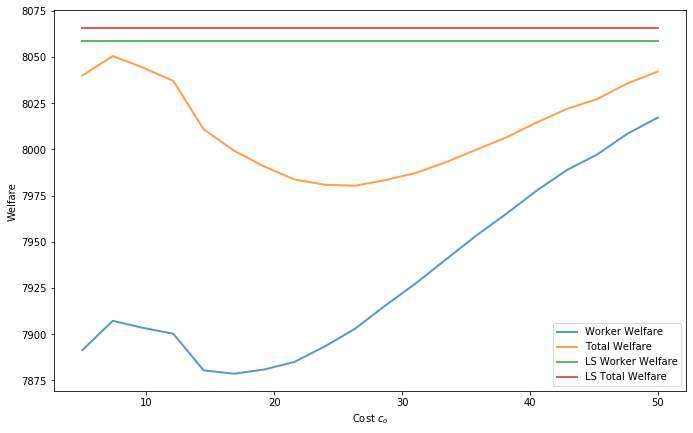

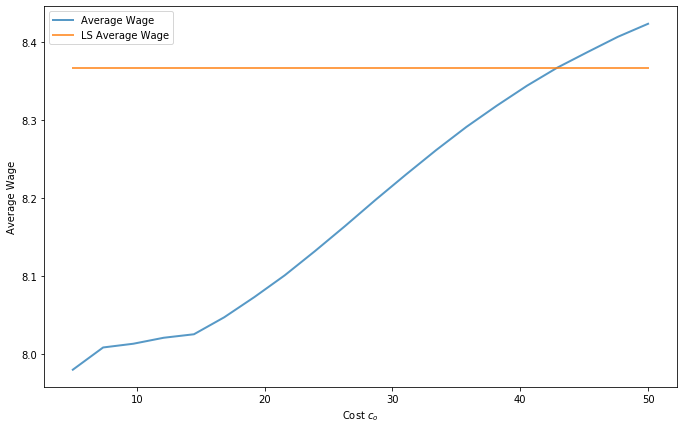

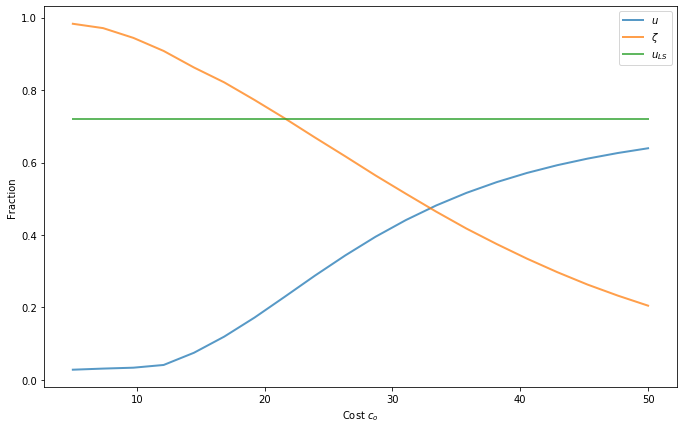

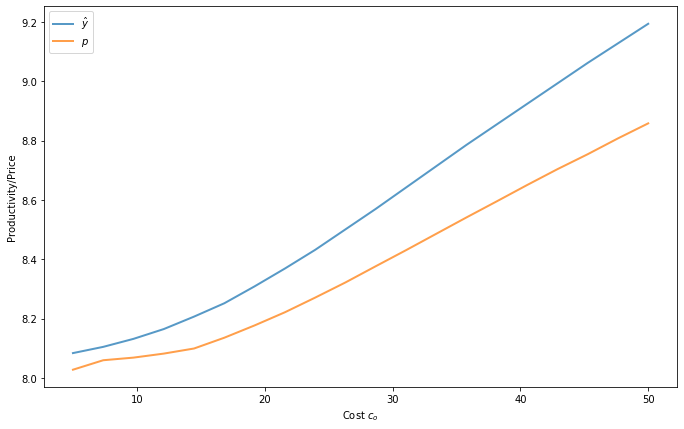

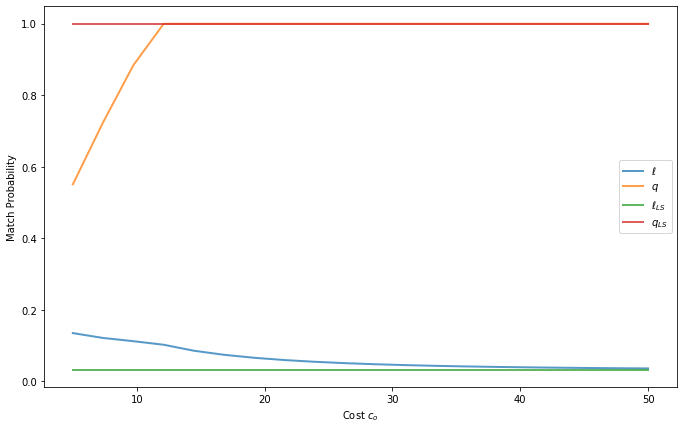

In [31]:
r = 0.0010010010010008674
B = 1 / (1 + r)
delta = 0.0038908798217776467
# delta_o = 0.00439118201841324
delta_o = delta
delta_hat = delta
alpha = .72
# alpha = 0.25
# eta = alpha
# eta_o = alpha
eta = alpha
eta_o = eta
# phi = 0.1
phi = 0.2
# phi = 0.05
y_min = 5
y_max = 11
# b = 7 * .7 
b = 4.732565099211391
# b = 0
y_grid_size = 2000
gamma = 2
y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
# c_0, c_1 = -13.36998614783188, 2.8688879501776086
c_0, c_1 = -15, 2.8688879501776086
c_grid = np.exp(c_0 + c_1 * y_grid)
c_o = None

params = (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
              y_min, y_max, y_grid_size, gamma, c_0, c_1, c_o)

tol = 1e-4
max_iter = 1.2e5
# tol = 1e-5
# max_iter = 2e5
# slow = 1e-1
# slow = 5e-2
slow = 1e-2

# save = True
save = False
folder = "C:/Users/spspi/Dropbox/Documents/Outsourcing/Figures/Python Simulations/Outsourcers vs LS 4/"

# compare_eqba(params, tol, max_iter, slow, verbose=True, out=False)

# c_o_grid = np.logspace(2, 4.5, 20, base = np.e)
# c_o_grid = np.linspace(10, 200, 20)
c_o_grid = np.linspace(5, 50, 20)

graph_cost_o(params, c_o_grid, tol=tol, max_iter=max_iter, slow=slow, verbose=False, height=7,  
                save=save, folder=folder)

In [2]:
r = 0.000939
B = 1 / (1 + r)
b = 7 * .7
delta = 0.003911083
delta_o = 0.004477807
alpha = .29
eta = alpha
y_min = 6
y_max = 10
y_grid_size = 2000
gamma = 2
y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
c_grid = np.exp(-13 + 2.5 * y_grid)
# c_o = np.exp(4)

tol = 1e-6
max_iter = 1e5
slow = 1e-1

delta_hat_grid = [delta - .001, delta]
eta_o_mult_grid = [0.8, 0.9, 1.0]
phi_grid = [.1, .2, .3]
c_o_grid = [np.exp(3), np.exp(4), np.exp(5)]
y_plus_grid = [-1, 0, 1]

(delta_hat_grid_m, eta_o_mult_grid_m, phi_grid_m, c_o_grid_m, y_plus_grid_m) = np.meshgrid(
    delta_hat_grid, eta_o_mult_grid, phi_grid, c_o_grid, y_plus_grid, indexing="ij"
)

output = np.empty(delta_hat_grid_m.shape + tuple([9]))

size = np.product(output.shape[:-1])

for i in range(size):
    ind = np.unravel_index(i, delta_hat_grid_m.shape)
    
    delta_hat = delta_hat_grid_m[ind]
    phi, c_o = phi_grid_m[ind], c_o_grid_m[ind]
    eta_o = eta * eta_o_mult_grid_m[ind]
    y_min_r, y_max_r = y_min + y_plus_grid_m[ind], y_max + y_plus_grid_m[ind]
    
    params = (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, alpha,
              y_min_r, y_max_r, y_grid_size, gamma, c_0, c_1, c_o)

    output[ind] = compare_eqba(params, tol, max_iter, slow, verbose=False, out=True)
    
interpret(output)

C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\spspi\Anaconda3\lib\site-packages\ipykernel_launcher.py:546: RuntimeWarning: inva

 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.23
p >= rho                                                         0.60
(y_hat >= y_hat_p) == (p >= rho)                                 0.48
Gamma_U >= Gamma_P                                               0.65
zeta >= zeta_p                                                   0.69
w_mean >= w_mean_ls                                              0.63
w_welfare >= w_welfare_ls                                        0.62
tot_welfare >= tot_welfare_ls                                    0.82
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.45
    


In [3]:
print(f"delta_hat = {delta_hat_grid[0]}")
interpret(output[0])
print(f"delta_hat = {delta_hat_grid[1]}")
interpret(output[1])

delta_hat = 0.002911083
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.27
p >= rho                                                         0.67
(y_hat >= y_hat_p) == (p >= rho)                                 0.46
Gamma_U >= Gamma_P                                               0.64
zeta >= zeta_p                                                   0.59
w_mean >= w_mean_ls                                              0.68
w_welfare >= w_welfare_ls                                        0.70
tot_welfare >= tot_welfare_ls                                    0.95
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.51
    
delta_hat = 0.003911083
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.19
p >= rho                                                         0.54
(y_hat >= y_hat_p) == (p >= rho)                                 0.49
Gamma_U >= Gamma_P     

In [6]:
# print(f"eta = {eta_grid[0]}")
# interpret(output[:, 0])
# print(f"eta = {eta_grid[1]}")
# interpret(output[:, 1])

eta = 0.29000000000000004
 
Fraction of outcomes where this is true
y_hat > y_hat_p                                                  0.21
p > rho                                                          0.90
(y_hat > y_hat_p) == (p > rho)                                   0.10
Gamma_U > Gamma_P                                                0.90
zeta > zeta_p                                                    0.71
u > u_ls                                                         0.06
w_mean > w_mean_ls                                               0.98
w_welfare > w_welfare_ls                                         0.48
tot_welfare > tot_welfare_ls                                     0.48
tot_welfare / tot_welfare_p > tot_welfare_ls / tot_welfare_ls_p  0.81
    
eta = 0.5
 
Fraction of outcomes where this is true
y_hat > y_hat_p                                                  0.29
p > rho                                                          0.96
(y_hat > y_hat_p) == (p > rho)     

In [4]:
print(f"eta_o_mult = {eta_o_mult_grid[0]}")
interpret(output[:, 0])
print(f"eta_o_mult = {eta_o_mult_grid[1]}")
interpret(output[:, 1])
print(f"eta_o_mult = {eta_o_mult_grid[2]}")
interpret(output[:, 2])

eta_o_mult = 0.8
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.20
p >= rho                                                         0.46
(y_hat >= y_hat_p) == (p >= rho)                                 0.56
Gamma_U >= Gamma_P                                               0.46
zeta >= zeta_p                                                   0.78
w_mean >= w_mean_ls                                              0.57
w_welfare >= w_welfare_ls                                        0.56
tot_welfare >= tot_welfare_ls                                    0.78
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.46
    
eta_o_mult = 0.9
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.20
p >= rho                                                         0.57
(y_hat >= y_hat_p) == (p >= rho)                                 0.48
Gamma_U >= Gamma_P                   

In [5]:
print(f"phi = {phi_grid[0]}")
interpret(output[:, :, 0])
print(f"phi = {phi_grid[1]}")
interpret(output[:, :, 1])
print(f"phi = {phi_grid[2]}")
interpret(output[:, :, 2])

phi = 0.1
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.31
p >= rho                                                         0.67
(y_hat >= y_hat_p) == (p >= rho)                                 0.65
Gamma_U >= Gamma_P                                               0.52
zeta >= zeta_p                                                   0.39
w_mean >= w_mean_ls                                              0.89
w_welfare >= w_welfare_ls                                        0.98
tot_welfare >= tot_welfare_ls                                    1.00
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.48
    
phi = 0.2
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.19
p >= rho                                                         0.67
(y_hat >= y_hat_p) == (p >= rho)                                 0.33
Gamma_U >= Gamma_P                                 

In [9]:
# print(f"gamma = {gamma_grid[0]}")
# interpret(output[:, :, :, :, 0])
# print(f"gamma = {gamma_grid[1]}")
# interpret(output[:, :, :, :, 1])
# print(f"gamma = {gamma_grid[2]}")
# interpret(output[:, :, :, :, 2])

gamma = 2
 
Fraction of outcomes where this is true
y_hat > y_hat_p                                                  0.53
p > rho                                                          1.00
(y_hat > y_hat_p) == (p > rho)                                   0.53
Gamma_U > Gamma_P                                                1.00
zeta > zeta_p                                                    0.31
u > u_ls                                                         0.06
w_mean > w_mean_ls                                               0.97
w_welfare > w_welfare_ls                                         0.91
tot_welfare > tot_welfare_ls                                     1.00
tot_welfare / tot_welfare_p > tot_welfare_ls / tot_welfare_ls_p  0.47
    
gamma = 4
 
Fraction of outcomes where this is true
y_hat > y_hat_p                                                  0.22
p > rho                                                          0.78
(y_hat > y_hat_p) == (p > rho)                     

In [6]:
print(f"c_o = {c_o_grid[0]}")
interpret(output[:, :, :, 0])
print(f"c_o = {c_o_grid[1]}")
interpret(output[:, :, :, 1])
print(f"c_o = {c_o_grid[2]}")
interpret(output[:, :, :, 2])

c_o = 20.085536923187668
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.22
p >= rho                                                         0.35
(y_hat >= y_hat_p) == (p >= rho)                                 0.50
Gamma_U >= Gamma_P                                               0.37
zeta >= zeta_p                                                   0.72
w_mean >= w_mean_ls                                              0.37
w_welfare >= w_welfare_ls                                        0.69
tot_welfare >= tot_welfare_ls                                    0.83
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.33
    
c_o = 54.598150033144236
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.06
p >= rho                                                         0.57
(y_hat >= y_hat_p) == (p >= rho)                                 0.48
Gamma_U >= Gamma_P   

In [7]:
print(f"y_plus = {y_plus_grid[0]}")
interpret(output[:, :, :, :, 0])
print(f"y_plus = {y_plus_grid[1]}")
interpret(output[:, :, :, :, 1])
print(f"y_plus = {y_plus_grid[2]}")
interpret(output[:, :, :, :, 2])

y_plus = -1
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.13
p >= rho                                                         0.48
(y_hat >= y_hat_p) == (p >= rho)                                 0.57
Gamma_U >= Gamma_P                                               0.59
zeta >= zeta_p                                                   0.69
w_mean >= w_mean_ls                                              0.46
w_welfare >= w_welfare_ls                                        0.39
tot_welfare >= tot_welfare_ls                                    0.76
tot_welfare / tot_welfare_p >= tot_welfare_ls / tot_welfare_ls_p 0.17
    
y_plus = 0
 
Fraction of outcomes where this is true
y_hat >= y_hat_p                                                 0.19
p >= rho                                                         0.70
(y_hat >= y_hat_p) == (p >= rho)                                 0.44
Gamma_U >= Gamma_P                              

In [8]:
size = np.product(output.shape[:-1])

for i in range(size):
    ind = np.unravel_index(i, delta_hat_grid_m.shape)
    
    print(ind, output[ind])

(0, 0, 0, 0) [0. 0. 1. 0. 1. 1. 1. 1. 1.]
(0, 0, 0, 1) [0. 0. 1. 0. 1. 1. 1. 1. 1.]
(0, 0, 0, 2) [1. 1. 1. 1. 0. 1. 1. 1. 0.]
(0, 0, 1, 0) [0. 1. 0. 0. 0. 1. 1. 1. 1.]
(0, 0, 1, 1) [0. 1. 0. 1. 1. 1. 1. 1. 1.]
(0, 0, 1, 2) [0. 1. 0. 1. 1. 1. 1. 1. 1.]
(0, 0, 2, 0) [1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0, 0, 2, 1) [0. 1. 0. 1. 1. 0. 0. 1. 1.]
(0, 0, 2, 2) [0. 1. 0. 1. 1. 1. 0. 1. 1.]
(0, 1, 0, 0) [0. 0. 1. 0. 0. 1. 1. 1. 1.]
(0, 1, 0, 1) [0. 1. 0. 0. 0. 1. 1. 1. 1.]
(0, 1, 0, 2) [1. 1. 1. 1. 0. 1. 1. 1. 0.]
(0, 1, 1, 0) [0. 0. 1. 0. 0. 1. 1. 1. 1.]
(0, 1, 1, 1) [0. 1. 0. 1. 1. 1. 1. 1. 1.]
(0, 1, 1, 2) [1. 1. 1. 1. 0. 1. 1. 1. 0.]
(0, 1, 2, 0) [0. 0. 1. 0. 1. 1. 1. 1. 1.]
(0, 1, 2, 1) [0. 1. 0. 1. 1. 0. 0. 1. 1.]
(0, 1, 2, 2) [0. 1. 0. 1. 1. 1. 0. 1. 1.]
(0, 2, 0, 0) [0. 1. 0. 1. 0. 1. 1. 1. 1.]
(0, 2, 0, 1) [1. 1. 1. 1. 0. 1. 1. 1. 0.]
(0, 2, 0, 2) [1. 1. 1. 1. 0. 1. 1. 1. 0.]
(0, 2, 1, 0) [0. 1. 0. 1. 0. 1. 1. 1. 1.]
(0, 2, 1, 1) [0. 1. 0. 1. 0. 1. 1. 1. 1.]
(0, 2, 1, 2) [1. 1. 1. 1. 0. 1. 1.

In [25]:
ind = (1, 1, 1, 1, 1, 0)
delta_hat, eta = delta_hat_grid_m[ind], eta_grid_m[ind]
phi, gamma, c_o = phi_grid_m[ind], gamma_grid_m[ind], c_o_grid_m[ind]
eta_o = eta * eta_o_mult_grid_m[ind]

tol = 1e-6
max_iter = 2e5
slow = 1e-2

params = (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, psi,
          y_min, y_max, y_grid_size, gamma, c_grid, c_o)

compare_eqba(params, tol, max_iter, slow, verbose=True, out=False)


Parameters
B = 0.9990618808938406; b = 4.8999999999999995, delta = 0.003911083, delta_o = 0.004477807, delta_hat = 0.003911083,
eta = 0.5, eta_o = 0.5, phi = 0.2, psi = 0.71, 
y_min = 6, y_max = 10, y_grid_size = 2000, gamma = 4, c_o = 54.598150033144236

For decentralized Outsourcer problem
y_hat = 10.00; p = 9.93; pi = 0.00; zeta = 0.00
u = 0.08; q(theta) = 0.37; ell(theta) = 0.05; Gamma_U = 3.42
w_welfare = 8.39; f_welfare = 0.27; o_welfare = 0.00; 
tot_welfare = 8.66; 
w_mean = 9.12

For Planner's Outsourcer problem
y_hat = 9.85; rho = 9.39; pi = 0.20; zeta = 0.18
u = 0.06; q(theta) = 0.33; ell(theta) = 0.06; Gamma_P = 3.29
tot_welfare = 8.73; 
Decentralized Percent of Welfare = 0.9920

For decentralized LS problem
u = 0.08; q(theta) = 0.37; ell(theta) = 0.05; Gamma_U = 3.42;
w_welfare = 8.39; f_welfare = 0.27;  
tot_welfare = 8.66; 
w_mean = 8.69

Decentralized Percent of Welfare = 0.9920
For Planner's LS problem
u = 0.07; q(theta) = 0.34; ell(theta) = 0.05; Gamma_P = 3.22
tot_we

In [24]:
ob = OutsourcingBaseline(B, b, delta, delta_o, delta_hat, eta, eta_o, phi, psi,
        y_min, y_max, y_grid_size, gamma, c_grid, c_o)
    
v_grid = np.ones(y_grid_size) / y_grid_size**2
n_grid = np.ones(y_grid_size) / y_grid_size**2
v_o = 1 / y_grid_size**2

guess = v_grid, v_grid, v_o, n_grid, n_grid, v_o, (y_max + y_min) / 2

max_iter = 2e5
slow = 1e-2

v_grid_p, v_hat_grid_p, v_o_p, n_grid_p, n_hat_grid_p, n_o_p, y_hat_p = solve_model(
        ob, guess, tol, max_iter, slow, planner=True, verbose=True)

Error at iter 0 is 0.2953
Error at iter 10000 is 0.0031
Error at iter 20000 is 0.0025
Error at iter 30000 is 0.0023
Error at iter 40000 is 0.0019
Error at iter 50000 is 0.0015
Error at iter 60000 is 0.0010
Error at iter 70000 is 0.0012
Error at iter 80000 is 0.0009
Error at iter 90000 is 0.0009
Error at iter 100000 is 0.0004
Error at iter 110000 is 0.0006
Error at iter 120000 is 0.0008
Error at iter 130000 is 0.0003
Error at iter 140000 is 0.0000
Error at iter 150000 is 0.0000
Error at iter 160000 is 0.0000
Error at iter 170000 is 0.0000
Error at iter 180000 is 0.0000
Error at iter 190000 is 0.0000
Failed to Converge.


In [117]:
b_grid = np.array([7 * .4, 7 * .7])
delta_hat_grid = np.array([delta - .0005, delta])

b_grid_2, delta_hat_grid_2 = np.meshgrid(b_grid, delta_hat_grid, indexing="ij")

output = np.empty(b_grid_2.shape + tuple([9]))

for i in range(4):
    ind = np.unravel_index(i, b_grid_2.shape)
    b = b_grid_2[ind]
    delta_hat = delta_hat_grid_2[ind]

    params = (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, psi,
              y_min, y_max, y_grid_size, gamma, c_grid, c_o)

    output[ind] = compare_eqba(params, tol, max_iter, slow, verbose=False, out=True)
    
interpret(output)

 
Fraction of outcomes where this is true
y_hat > y_hat_p :                                                 0.75
p > rho :                                                         0.75
Gamma_U > Gamma_P :                                               0.75
u > u_ls :                                                        0.00
w_mean > w_mean_ls :                                              1.00
w_welfare > w_welfare_ls :                                        1.00
tot_welfare > tot_welfare_ls :                                    1.00
tot_welfare / tot_welfare_p > tot_welfare_ls / tot_welfare_ls_p : 0.50
    


In [10]:
interpret(output[])

 
Fraction of outcomes where this is true
y_hat > y_hat_p                                                  0.14
p > rho                                                          0.29
Gamma_U > Gamma_P                                                0.16
(y_hat > y_hat_p) == (p > rho)                                   0.31
u > u_ls                                                         0.21
w_mean > w_mean_ls                                               0.25
w_welfare > w_welfare_ls                                         0.22
tot_welfare > tot_welfare_ls                                     0.21
tot_welfare / tot_welfare_p > tot_welfare_ls / tot_welfare_ls_p  0.24
    


In [13]:
output[ind]

array([1., 0., 0., 0., 0., 1., 0., 0., 1.])

In [3]:
%debug

> <ipython-input-2-d907fd29d645>(35)<module>()
     33     b, delta_hat, eta = b_grid_m[ind], delta_hat_grid_m[ind], eta_grid_m[ind]
     34     gamma, phi, c_o = gamma_grid_m[ind], phi_grid_m[ind], c_o_grid_m[ind]
---> 35     eta_o = eta * eta_o_mult_grid[ind]
     36 
     37     params = (B, b, delta, delta_o, delta_hat, eta, eta_o, phi, psi,

ipdb> eta
0.29000000000000004
ipdb> eta_o_mult_grid[ind]
*** TypeError: list indices must be integers or slices, not tuple
ipdb> eta_o_mult_grid_m[ind]
0.9
ipdb> c


Converged in 18951 iterations
Converged in 18183 iterations
Converged in 23324 iterations
Converged in 22566 iterations
Converged in 20138 iterations
Converged in 20386 iterations
Converged in 19243 iterations
Converged in 19646 iterations


TypeError: cannot unpack non-iterable function object

8